In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set seed untuk reproduksibilitas
np.random.seed(42)

# --- Membuat Dataset Dummy "Sangat Hancur" ---
n = 10000
feature1 = np.concatenate([np.random.exponential(scale=100, size=int(n * 0.85)), np.random.uniform(1000, 20000, int(n * 0.15))])
feature2 = np.concatenate([np.random.uniform(0, 500, int(n * 0.80)), np.random.uniform(5000, 10000, int(n * 0.20))])
feature2[np.random.choice(n, int(n * 0.25), replace=False)] = np.nan
feature3 = np.random.choice(['A', 'B', 'C', 'D', 'E'], n)
feature4 = np.concatenate([np.random.normal(50, 10, int(n * 0.90)), np.random.uniform(500, 1500, int(n * 0.10))])
feature4[np.random.choice(n, int(n * 0.20), replace=False)] = np.nan
target = np.random.choice([0, 1], n, p=[0.9, 0.1])

data = pd.DataFrame({
    'Feature1': feature1,
    'Feature2': feature2,
    'Feature3': feature3,
    'Feature4': feature4,
    'Target': target
})


=== Exploratory Data Analysis (EDA) ===
Analisis awal untuk memahami karakteristik dataset dan kebutuhan pra-pemrosesan untuk KNN.

1. Skala dan Rentang Fitur Numerik:
Statistik deskriptif untuk memeriksa rentang dan distribusi awal fitur numerik:
           Feature1     Feature2     Feature4
count  10000.000000  7500.000000  8000.000000
mean    1639.721759  1674.797592   142.781237
std     4211.120160  2966.793328   295.081890
min        0.001163     0.078872     5.343961
25%       33.651771   158.543597    43.767939
50%       86.875845   310.377785    51.105661
75%      211.118481   466.813388    59.535007
max    19990.598604  9999.357191  1499.672307
- Alasan: KNN sensitif terhadap skala fitur; perbedaan skala besar dapat mendominasi perhitungan jarak.


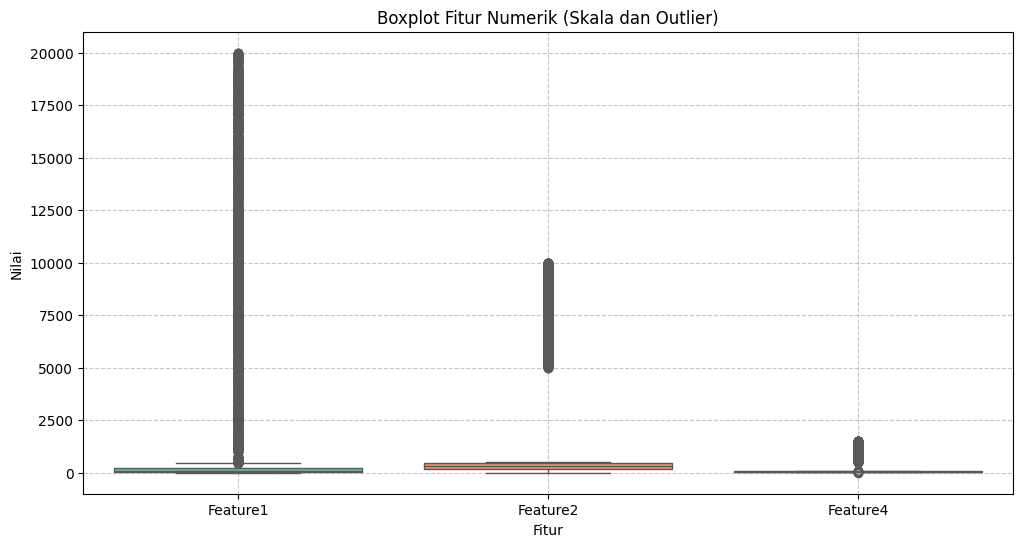

In [3]:

# --- Langkah 2: Exploratory Data Analysis (EDA) ---
print("\n=== Exploratory Data Analysis (EDA) ===")
print("Analisis awal untuk memahami karakteristik dataset dan kebutuhan pra-pemrosesan untuk KNN.")

# 1. Skala dan Rentang Fitur
print("\n1. Skala dan Rentang Fitur Numerik:")
print("Statistik deskriptif untuk memeriksa rentang dan distribusi awal fitur numerik:")
print(data[['Feature1', 'Feature2', 'Feature4']].describe())
print("- Alasan: KNN sensitif terhadap skala fitur; perbedaan skala besar dapat mendominasi perhitungan jarak.")
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Feature1', 'Feature2', 'Feature4']], palette='Set2')
plt.title("Boxplot Fitur Numerik (Skala dan Outlier)")
plt.xlabel("Fitur")
plt.ylabel("Nilai")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


2. Distribusi Fitur dan Skewness:
Memeriksa distribusi dan kemiringan (skewness) untuk setiap fitur numerik:
- Feature1: Skewness = 2.80
  Interpretasi: Sangat miring positif
- Feature2: Skewness = 1.71
  Interpretasi: Sangat miring positif
- Feature4: Skewness = 3.14
  Interpretasi: Sangat miring positif
- Alasan: Skewness tinggi dapat memengaruhi perhitungan jarak KNN karena distribusi tidak merata.


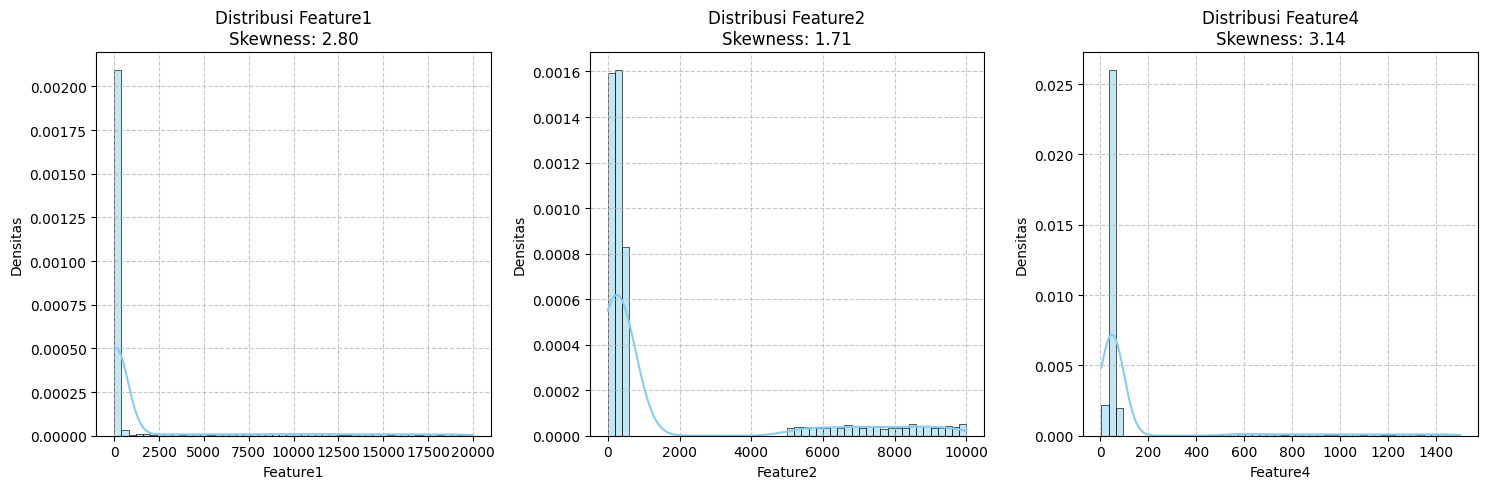

In [5]:
# Fungsi manual untuk menghitung skewness menggunakan numpy
def calculate_skewness(x):
    n = len(x)
    if n < 3:  # Skewness tidak bisa dihitung untuk n < 3
        return np.nan
    mean_x = np.mean(x)
    std_x = np.std(x, ddof=1)  # ddof=1 untuk sample standard deviation
    if std_x == 0:  # Hindari pembagian dengan nol
        return 0
    skew = np.sum(((x - mean_x) / std_x) ** 3) * (n / ((n - 1) * (n - 2)))
    return skew

# 2. Distribusi Fitur dan Skewness
print("\n2. Distribusi Fitur dan Skewness:")
print("Memeriksa distribusi dan kemiringan (skewness) untuk setiap fitur numerik:")
for col in ['Feature1', 'Feature2', 'Feature4']:
    skewness = calculate_skewness(data[col].dropna())
    print(f"- {col}: Skewness = {skewness:.2f}")
    print(f"  Interpretasi: {'Sangat miring positif' if skewness > 1 else 'Miring negatif' if skewness < -1 else 'Cukup simetris'}")
print("- Alasan: Skewness tinggi dapat memengaruhi perhitungan jarak KNN karena distribusi tidak merata.")
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Feature1', 'Feature2', 'Feature4'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col].dropna(), kde=True, bins=50, color='skyblue', stat='density')
    plt.title(f"Distribusi {col}\nSkewness: {calculate_skewness(data[col].dropna()):.2f}")
    plt.xlabel(col)
    plt.ylabel("Densitas")
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
# 3. Deteksi Outlier dengan IQR
print("\n3. Deteksi Outlier (Metode IQR):")
print("Menghitung jumlah outlier untuk setiap fitur numerik menggunakan metode Interquartile Range (IQR):")
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers), lower_bound, upper_bound

for col in ['Feature1', 'Feature2', 'Feature4']:
    n_outliers, lower, upper = detect_outliers_iqr(data, col)
    print(f"- {col}: {n_outliers} outlier (Batas: {lower:.2f} - {upper:.2f})")
print("- Alasan: Outlier di semua fitur dapat mendistorsi perhitungan jarak KNN, memerlukan penanganan khusus.")


3. Deteksi Outlier (Metode IQR):
Menghitung jumlah outlier untuk setiap fitur numerik menggunakan metode Interquartile Range (IQR):
- Feature1: 1562 outlier (Batas: -232.55 - 477.32)
- Feature2: 1461 outlier (Batas: -303.86 - 929.22)
- Feature4: 815 outlier (Batas: 20.12 - 83.19)
- Alasan: Outlier di semua fitur dapat mendistorsi perhitungan jarak KNN, memerlukan penanganan khusus.



4. Missing Values:
Persentase nilai hilang untuk setiap kolom:
Feature1     0.0
Feature2    25.0
Feature3     0.0
Feature4    20.0
Target       0.0
dtype: float64
- Alasan: KNN tidak dapat memproses nilai hilang (NaN), sehingga imputasi diperlukan.


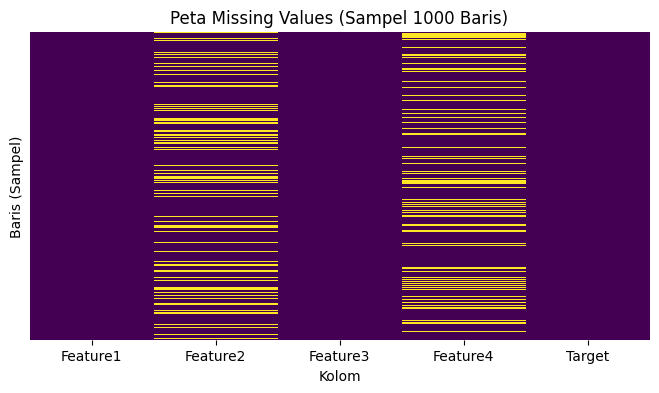

In [7]:
# 4. Missing Values
print("\n4. Missing Values:")
print("Persentase nilai hilang untuk setiap kolom:")
missing_percentage = data.isna().mean() * 100
print(missing_percentage)
print("- Alasan: KNN tidak dapat memproses nilai hilang (NaN), sehingga imputasi diperlukan.")
plt.figure(figsize=(8, 4))
sns.heatmap(data.isna().sample(1000), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Peta Missing Values (Sampel 1000 Baris)")
plt.xlabel("Kolom")
plt.ylabel("Baris (Sampel)")
plt.show()


5. Distribusi Kelas Target:
Persentase distribusi kelas target untuk mengevaluasi ketidakseimbangan:
Target
0    89.64
1    10.36
Name: proportion, dtype: float64
- Alasan: Ketidakseimbangan kelas ekstrem dapat menyebabkan bias pada KNN, memerlukan teknik seperti oversampling.


<ipython-input-8-a937e051c25a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=data, palette='Set1')


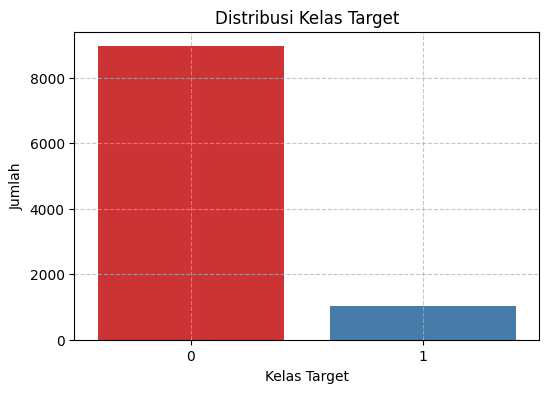

In [8]:
# 5. Distribusi Target
print("\n5. Distribusi Kelas Target:")
print("Persentase distribusi kelas target untuk mengevaluasi ketidakseimbangan:")
target_dist = data['Target'].value_counts(normalize=True) * 100
print(target_dist)
print("- Alasan: Ketidakseimbangan kelas ekstrem dapat menyebabkan bias pada KNN, memerlukan teknik seperti oversampling.")
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=data, palette='Set1')
plt.title("Distribusi Kelas Target")
plt.xlabel("Kelas Target")
plt.ylabel("Jumlah")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


6. Pairplot (Sampel 1000 Baris):
Visualisasi hubungan antar fitur numerik dan distribusi berdasarkan kelas target:


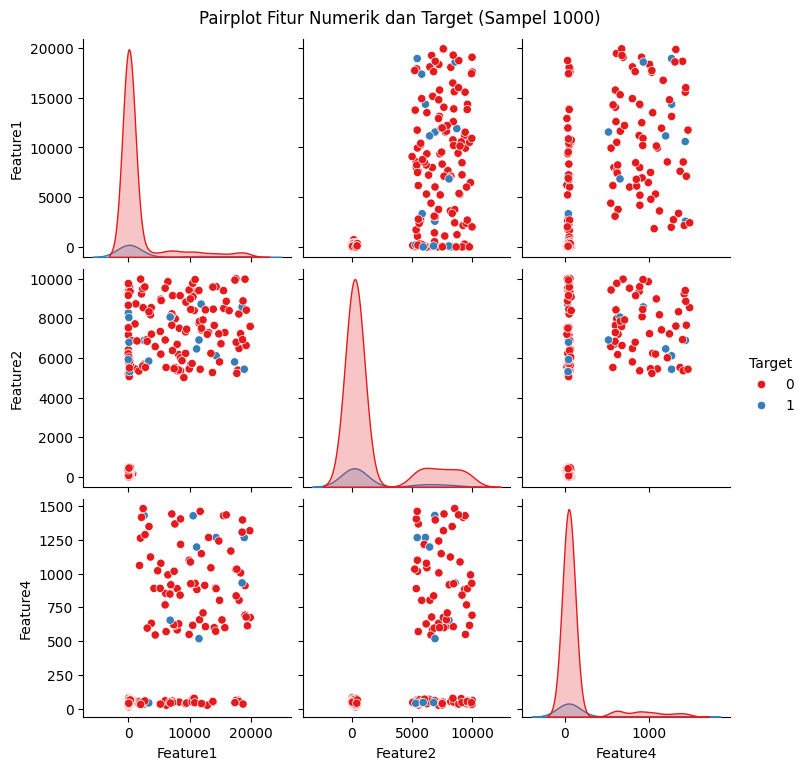

- Alasan: Pairplot menunjukkan overlap kelas, noise, dan potensi hubungan non-linier yang perlu diperhatikan.


In [9]:
# 6. Pairplot untuk Hubungan Antar Fitur
print("\n6. Pairplot (Sampel 1000 Baris):")
print("Visualisasi hubungan antar fitur numerik dan distribusi berdasarkan kelas target:")
sns.pairplot(data[['Feature1', 'Feature2', 'Feature4', 'Target']].sample(1000), hue='Target', diag_kind='kde', palette='Set1')
plt.suptitle("Pairplot Fitur Numerik dan Target (Sampel 1000)", y=1.02)
plt.show()
print("- Alasan: Pairplot menunjukkan overlap kelas, noise, dan potensi hubungan non-linier yang perlu diperhatikan.")


=== Pra-Pemrosesan Data ===
Langkah-langkah untuk mempersiapkan data agar sesuai dengan kebutuhan KNN.

1. Penanganan Outlier (IQR Multi-Dimensi + Log Transformasi):
Sebelum penanganan outlier:
           Feature1     Feature2     Feature4
count  10000.000000  7500.000000  8000.000000
mean    1639.721759  1674.797592   142.781237
std     4211.120160  2966.793328   295.081890
min        0.001163     0.078872     5.343961
25%       33.651771   158.543597    43.767939
50%       86.875845   310.377785    51.105661
75%      211.118481   466.813388    59.535007
max    19990.598604  9999.357191  1499.672307
Jumlah baris awal: 10000
Jumlah baris setelah dropna: 5971
Jumlah baris setelah IQR Multi-Dimensi: 4750
Sesudah penanganan outlier dan transformasi:
          Feature1     Feature2     Feature4
count  4750.000000  4750.000000  4750.000000
mean      4.039336     5.234343    49.787339
std       1.164333     0.956818     9.729671
min       0.001163     0.075916    22.894334
25%       3.37580

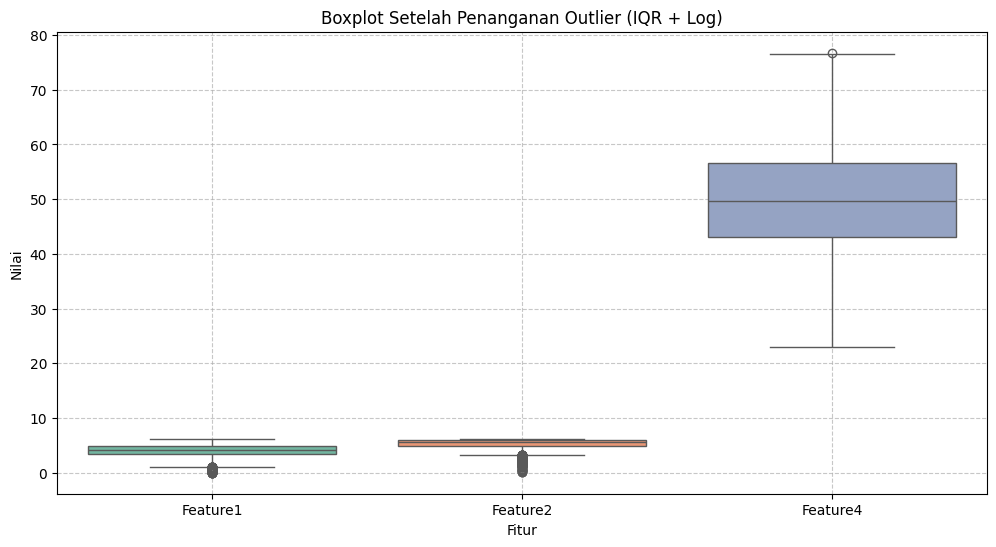

- Alasan: IQR Multi-Dimensi menghapus outlier per fitur; Log Transformasi mengurangi skewness pada Feature1 dan Feature2.


In [10]:
# --- Langkah 3: Pra-Pemrosesan Data ---
print("\n=== Pra-Pemrosesan Data ===")
print("Langkah-langkah untuk mempersiapkan data agar sesuai dengan kebutuhan KNN.")

# 1. Penanganan Outlier dengan IQR Multi-Dimensi dan Log Transformasi
print("\n1. Penanganan Outlier (IQR Multi-Dimensi + Log Transformasi):")
print("Sebelum penanganan outlier:")
print(data[['Feature1', 'Feature2', 'Feature4']].describe())
data_clean = data.copy()
print(f"Jumlah baris awal: {len(data_clean)}")

# Terapkan IQR Multi-Dimensi pada data numerik tanpa missing values
numeric_data = data_clean[['Feature1', 'Feature2', 'Feature4']].dropna()
print(f"Jumlah baris setelah dropna: {len(numeric_data)}")

# Fungsi untuk mendeteksi outlier berbasis IQR per kolom
def remove_outliers_iqr(df, columns):
    df_temp = df.copy()
    for col in columns:
        Q1 = df_temp[col].quantile(0.25)
        Q3 = df_temp[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_temp = df_temp[(df_temp[col] >= lower_bound) & (df_temp[col] <= upper_bound)]
    return df_temp

# Terapkan IQR untuk menghapus outlier
data_clean_no_outliers = remove_outliers_iqr(numeric_data, ['Feature1', 'Feature2', 'Feature4'])
valid_indices = data_clean_no_outliers.index
data_clean = data_clean.loc[valid_indices]
print(f"Jumlah baris setelah IQR Multi-Dimensi: {len(data_clean)}")

# Terapkan Log Transformasi pada Feature1 dan Feature2 untuk mengurangi skewness
for col in ['Feature1', 'Feature2']:
    data_clean[col] = np.log1p(data_clean[col].clip(lower=0))
print("Sesudah penanganan outlier dan transformasi:")
print(data_clean[['Feature1', 'Feature2', 'Feature4']].describe())
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_clean[['Feature1', 'Feature2', 'Feature4']], palette='Set2')
plt.title("Boxplot Setelah Penanganan Outlier (IQR + Log)")
plt.xlabel("Fitur")
plt.ylabel("Nilai")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: IQR Multi-Dimensi menghapus outlier per fitur; Log Transformasi mengurangi skewness pada Feature1 dan Feature2.")

In [11]:
# 2. Encoding Fitur Kategorikal dengan One-Hot Encoding
print("\n2. Encoding Kategorikal (One-Hot Encoding):")
print("Sebelum encoding:")
print(data_clean['Feature3'].value_counts())
data_encoded = pd.get_dummies(data_clean, columns=['Feature3'], prefix='Feature3')
print("Sesudah encoding:")
print(data_encoded.head())
print(f"Dimensi data setelah encoding: {data_encoded.shape}")
print("- Alasan: One-Hot Encoding mengubah fitur kategorikal menjadi numerik tanpa asumsi ordinalitas, sesuai untuk KNN.")


2. Encoding Kategorikal (One-Hot Encoding):
Sebelum encoding:
Feature3
A    973
B    971
D    962
C    926
E    918
Name: count, dtype: int64
Sesudah encoding:
    Feature1  Feature2   Feature4  Target  Feature3_A  Feature3_B  Feature3_C  \
3   4.524982  5.719109  58.382240       0       False        True       False   
6   1.943604  2.836431  45.639307       0        True       False       False   
7   5.308877  5.777448  52.203957       1       False        True       False   
10  1.124907  6.095908  45.197417       0       False        True       False   
11  5.861799  5.901312  37.816194       0        True       False       False   

    Feature3_D  Feature3_E  
3        False       False  
6        False       False  
7        False       False  
10       False       False  
11       False       False  
Dimensi data setelah encoding: (4750, 9)
- Alasan: One-Hot Encoding mengubah fitur kategorikal menjadi numerik tanpa asumsi ordinalitas, sesuai untuk KNN.


In [12]:
# 3. Penanganan Missing Values dengan KNN Imputation Manual
print("\n3. Penanganan Missing Values (KNN Imputation):")
print("Sebelum imputasi:")
print(data_encoded.isna().sum())

# Fungsi manual untuk KNN Imputation
def manual_knn_impute(df, column, k=5):
    df_temp = df.copy()
    # Pisahkan data dengan dan tanpa nilai hilang
    missing_idx = df_temp[column].isna()
    complete_data = df_temp[~missing_idx].drop(columns='Target')
    missing_data = df_temp[missing_idx].drop(columns='Target')

    if missing_data.empty or complete_data.empty:
        return df_temp

    # Ambil fitur numerik untuk perhitungan jarak
    features = [col for col in complete_data.columns if col != column or col.startswith('Feature3')]

    for idx in missing_data.index:
        # Hitung jarak Euclidean ke semua data lengkap
        distances = np.sqrt(((complete_data[features] - missing_data.loc[idx, features]) ** 2).sum(axis=1))
        # Urutkan dan ambil k tetangga terdekat
        nearest_idx = distances.argsort()[:k]
        nearest_values = complete_data.iloc[nearest_idx][column]
        # Imputasi dengan rata-rata tetangga terdekat
        df_temp.loc[idx, column] = nearest_values.mean()

    return df_temp

# Terapkan imputasi manual pada kolom dengan missing values
data_imputed = data_encoded.copy()
for col in ['Feature2', 'Feature4']:  # Kolom dengan nilai hilang
    data_imputed = manual_knn_impute(data_imputed, col, k=5)

print("Sesudah imputasi:")
print(data_imputed.isna().sum())
print("Statistik deskriptif setelah imputasi:")
print(data_imputed[['Feature1', 'Feature2', 'Feature4']].describe())
print("- Alasan: KNN Imputation manual menggunakan tetangga terdekat untuk mengisi nilai hilang, konsisten dengan prinsip KNN.")


3. Penanganan Missing Values (KNN Imputation):
Sebelum imputasi:
Feature1      0
Feature2      0
Feature4      0
Target        0
Feature3_A    0
Feature3_B    0
Feature3_C    0
Feature3_D    0
Feature3_E    0
dtype: int64
Sesudah imputasi:
Feature1      0
Feature2      0
Feature4      0
Target        0
Feature3_A    0
Feature3_B    0
Feature3_C    0
Feature3_D    0
Feature3_E    0
dtype: int64
Statistik deskriptif setelah imputasi:
          Feature1     Feature2     Feature4
count  4750.000000  4750.000000  4750.000000
mean      4.039336     5.234343    49.787339
std       1.164333     0.956818     9.729671
min       0.001163     0.075916    22.894334
25%       3.375805     4.843472    43.076207
50%       4.218317     5.533118    49.720737
75%       4.898851     5.940721    56.537559
max       6.124002     6.215942    76.770605
- Alasan: KNN Imputation manual menggunakan tetangga terdekat untuk mengisi nilai hilang, konsisten dengan prinsip KNN.



4. Standarisasi (Robust Scaling Manual):
Sebelum standarisasi:
          Feature1     Feature2     Feature4
count  4750.000000  4750.000000  4750.000000
mean      4.039336     5.234343    49.787339
std       1.164333     0.956818     9.729671
min       0.001163     0.075916    22.894334
25%       3.375805     4.843472    43.076207
50%       4.218317     5.533118    49.720737
75%       4.898851     5.940721    56.537559
max       6.124002     6.215942    76.770605
Sesudah standarisasi:
          Feature1      Feature2     Feature4
count  4750.000000  4.750000e+03  4750.000000
mean     -0.117515 -2.722941e-01     0.004948
std       0.764476  8.720151e-01     0.722786
min      -2.768894 -4.973528e+00    -1.992846
25%      -0.553176 -6.285225e-01    -0.493601
50%       0.000000 -4.047327e-16     0.000000
75%       0.446824  3.714775e-01     0.506399
max       1.251233  6.223055e-01     2.009447


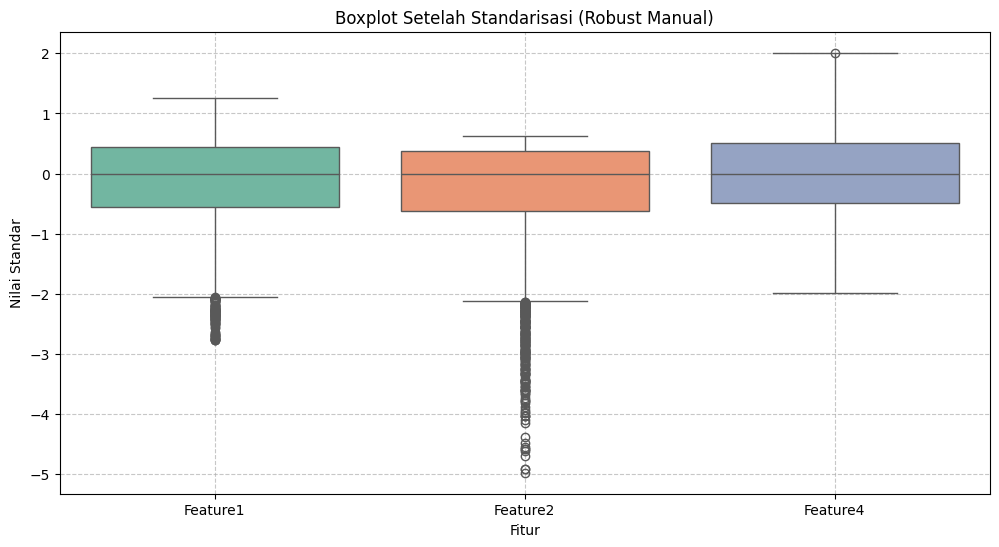

- Alasan: Robust scaling manual menormalkan skala fitur dengan ketahanan terhadap outlier, penting untuk KNN berbasis jarak.


In [13]:
# 4. Standarisasi Fitur Numerik dengan Robust Scaling Manual
print("\n4. Standarisasi (Robust Scaling Manual):")
print("Sebelum standarisasi:")
print(data_imputed[['Feature1', 'Feature2', 'Feature4']].describe())

# Fungsi manual untuk robust scaling: (x - median) / IQR
def manual_robust_scale(df, columns):
    df_scaled = df.copy()
    for col in columns:
        median = df[col].median()
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:  # Hindari pembagian dengan nol
            IQR = 1
        df_scaled[col] = (df[col] - median) / IQR
    return df_scaled

# Terapkan standarisasi manual
features_to_scale = ['Feature1', 'Feature2', 'Feature4']
data_imputed = manual_robust_scale(data_imputed, features_to_scale)

print("Sesudah standarisasi:")
print(data_imputed[['Feature1', 'Feature2', 'Feature4']].describe())
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_imputed[features_to_scale], palette='Set2')
plt.title("Boxplot Setelah Standarisasi (Robust Manual)")
plt.xlabel("Fitur")
plt.ylabel("Nilai Standar")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: Robust scaling manual menormalkan skala fitur dengan ketahanan terhadap outlier, penting untuk KNN berbasis jarak.")


5. Reduksi Dimensi (PCA Manual dengan 99% Varians):
Sebelum PCA:
Jumlah fitur: 8
Jumlah komponen untuk 99% varians: 7
Sesudah PCA:
                PC1           PC2           PC3           PC4           PC5  \
count  4.750000e+03  4.750000e+03  4.750000e+03  4.750000e+03  4.750000e+03   
mean   3.141347e-17  3.216141e-17 -5.235578e-18 -1.907246e-17 -9.723216e-18   
std    8.732839e-01  7.646805e-01  7.214433e-01  4.521613e-01  4.507702e-01   
min   -1.034820e+00 -2.689361e+00 -2.028545e+00 -8.302411e-01 -8.012014e-01   
25%   -6.407085e-01 -4.412939e-01 -5.035868e-01 -5.236088e-03 -9.583030e-02   
50%   -2.560562e-01  1.146967e-01  4.082216e-03  3.283040e-02 -5.603775e-02   
75%    3.560845e-01  5.621279e-01  4.913068e-01  9.678615e-02  3.722227e-01   
max    4.680832e+00  1.477738e+00  2.122983e+00  6.867497e-01  5.650234e-01   

                PC6           PC7       Target  
count  4.750000e+03  4.750000e+03  4750.000000  
mean  -9.349247e-18  8.601307e-18     0.102105  
std    4.

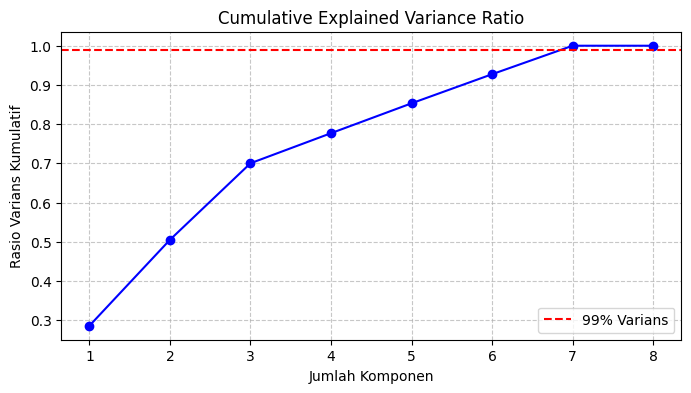

- Alasan: PCA manual dengan 99% varians mengurangi dimensi sambil mempertahankan informasi maksimal, meningkatkan efisiensi KNN.


In [15]:
# 5. Reduksi Dimensi dengan PCA Manual (99% Varians)
print("\n5. Reduksi Dimensi (PCA Manual dengan 99% Varians):")
print("Sebelum PCA:")
print(f"Jumlah fitur: {data_imputed.shape[1] - 1}")
X_for_pca = data_imputed.drop(columns='Target')

# Pastikan hanya kolom numerik yang digunakan untuk PCA
numeric_columns = ['Feature1', 'Feature2', 'Feature4', 'Feature3_A', 'Feature3_B', 'Feature3_C', 'Feature3_D', 'Feature3_E']
X_for_pca = X_for_pca[numeric_columns].astype(float)  # Konversi ke float untuk memastikan tipe numerik

# Fungsi manual untuk PCA menggunakan SVD
def manual_pca(X, variance_threshold=0.99):
    # Standarisasi data (centered ke mean)
    X_centered = X - np.nanmean(X, axis=0)  # Gunakan nanmean untuk menangani potensi NaN
    # Ganti NaN dengan 0 untuk perhitungan SVD (asumsi sederhana)
    X_centered = np.nan_to_num(X_centered, nan=0.0)
    # Hitung matriks kovariansi
    cov_matrix = np.dot(X_centered.T, X_centered) / (X_centered.shape[0] - 1)
    # Dekomposisi SVD
    U, S, Vt = np.linalg.svd(cov_matrix)
    # Hitung rasio varians yang dijelaskan
    explained_variance = S / S.sum()
    explained_variance_ratio = explained_variance.cumsum()
    # Tentukan jumlah komponen untuk 99% varians
    n_components = np.argmax(explained_variance_ratio >= variance_threshold) + 1
    # Proyeksikan data ke komponen utama
    components = Vt[:n_components]
    X_transformed = np.dot(X_centered, components.T)
    return X_transformed, n_components, explained_variance_ratio

# Terapkan PCA manual
X_pca, n_components, explained_variance_ratio = manual_pca(X_for_pca.values)
data_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
data_pca['Target'] = data_imputed['Target'].values

print(f"Jumlah komponen untuk 99% varians: {n_components}")
print("Sesudah PCA:")
print(data_pca.describe())
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', color='b')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Varians')
plt.title("Cumulative Explained Variance Ratio")
plt.xlabel("Jumlah Komponen")
plt.ylabel("Rasio Varians Kumulatif")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: PCA manual dengan 99% varians mengurangi dimensi sambil mempertahankan informasi maksimal, meningkatkan efisiensi KNN.")


6. Penanganan Ketidakseimbangan Kelas (Manual Oversampling):
Sebelum oversampling:
Target
0    89.789474
1    10.210526
Name: proportion, dtype: float64
Sesudah oversampling:
Target
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64
Jumlah baris setelah oversampling: 8530


<ipython-input-16-6f99828fa221>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=data_balanced, palette='Set1')


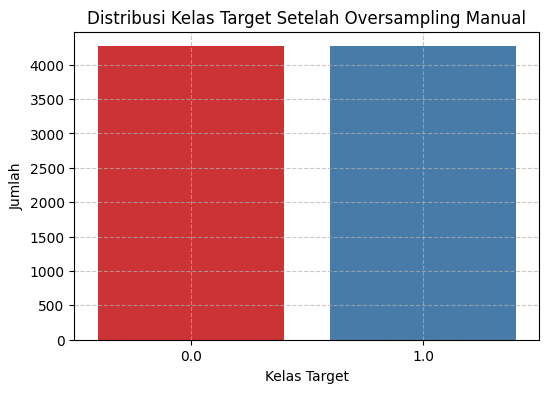

- Alasan: Oversampling manual menyeimbangkan kelas (50:50) untuk mencegah bias KNN terhadap kelas mayoritas.


In [16]:
# 6. Penanganan Ketidakseimbangan Kelas dengan Manual Oversampling
print("\n6. Penanganan Ketidakseimbangan Kelas (Manual Oversampling):")
print("Sebelum oversampling:")
print(data_pca['Target'].value_counts(normalize=True) * 100)

# Pisahkan fitur dan target
X = data_pca.drop(columns='Target')
y = data_pca['Target']

# Fungsi manual oversampling sederhana
def manual_oversample(X, y, target_ratio=1.0):
    # Hitung jumlah sampel per kelas
    class_counts = y.value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    n_majority = class_counts[majority_class]
    n_minority = class_counts[minority_class]

    # Tentukan jumlah sampel tambahan yang diperlukan
    n_to_generate = int(n_majority * target_ratio) - n_minority
    if n_to_generate <= 0:
        return X, y

    # Ambil data kelas minoritas
    X_minority = X[y == minority_class].values
    n_samples = X_minority.shape[0]

    # Generate sampel baru dengan interpolasi acak
    new_samples = []
    for _ in range(n_to_generate):
        # Pilih dua sampel acak dari kelas minoritas
        idx1, idx2 = np.random.choice(n_samples, 2, replace=False)
        sample1, sample2 = X_minority[idx1], X_minority[idx2]
        # Interpolasi linier acak
        alpha = np.random.random()
        new_sample = sample1 + alpha * (sample2 - sample1)
        new_samples.append(new_sample)

    # Gabungkan data baru
    X_new = np.vstack([X.values, np.array(new_samples)])
    y_new = np.hstack([y.values, np.ones(n_to_generate) * minority_class])
    return pd.DataFrame(X_new, columns=X.columns), pd.Series(y_new, name='Target')

# Terapkan oversampling manual untuk rasio 1:1
X_balanced, y_balanced = manual_oversample(X, y, target_ratio=1.0)
data_balanced = pd.concat([X_balanced, y_balanced], axis=1)

print("Sesudah oversampling:")
print(data_balanced['Target'].value_counts(normalize=True) * 100)
print(f"Jumlah baris setelah oversampling: {len(data_balanced)}")
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=data_balanced, palette='Set1')
plt.title("Distribusi Kelas Target Setelah Oversampling Manual")
plt.xlabel("Kelas Target")
plt.ylabel("Jumlah")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: Oversampling manual menyeimbangkan kelas (50:50) untuk mencegah bias KNN terhadap kelas mayoritas.")


=== Penerapan KNN Dasar ===
Menerapkan KNN dengan tuning hyperparameter untuk performa optimal.
Ukuran training set: 6824 baris, 7 fitur
Ukuran test set: 1706 baris, 7 fitur

Tuning Hyperparameter KNN secara Manual:
Parameter Terbaik: {'n_neighbors': 3, 'metric': 'euclidean'}

Performa KNN Dasar:
Akurasi pada Test Set: 0.7567
Confusion Matrix:
[[648 190]
 [225 643]]


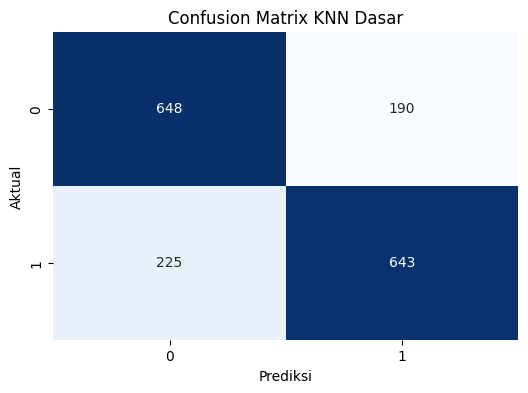

- Alasan: KNN manual diterapkan untuk klasifikasi dengan evaluasi akurasi dan confusion matrix.


In [17]:
# --- Langkah 4: Penerapan KNN Dasar ---
print("\n=== Penerapan KNN Dasar ===")
print("Menerapkan KNN dengan tuning hyperparameter untuk performa optimal.")
X = data_balanced.drop(columns='Target')
y = data_balanced['Target']

# Manual train-test split
def manual_train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    n = len(X)
    indices = np.random.permutation(n)
    test_size = int(n * test_size)
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

X_train, X_test, y_train, y_test = manual_train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Ukuran training set: {X_train.shape[0]} baris, {X_train.shape[1]} fitur")
print(f"Ukuran test set: {X_test.shape[0]} baris, {X_test.shape[1]} fitur")

# Manual KNN Classifier
def manual_knn_predict(X_train, y_train, X_test, k=5, metric='euclidean'):
    y_pred = []
    for i in range(len(X_test)):
        # Hitung jarak Euclidean
        distances = np.sqrt(((X_train - X_test.iloc[i]) ** 2).sum(axis=1))
        # Ambil k tetangga terdekat
        nearest_idx = distances.argsort()[:k]
        nearest_labels = y_train.iloc[nearest_idx]
        # Prediksi berdasarkan mayoritas
        pred = np.bincount(nearest_labels.astype(int)).argmax()
        y_pred.append(pred)
    return np.array(y_pred)

# Manual tuning hyperparameter (sederhana: hanya k)
print("\nTuning Hyperparameter KNN secara Manual:")
k_values = [3, 5, 7, 9, 11]
best_k = 5
best_accuracy = 0
for k in k_values:
    y_pred_temp = manual_knn_predict(X_train, y_train, X_test, k=k)
    accuracy = np.mean(y_pred_temp == y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print(f"Parameter Terbaik: {{'n_neighbors': {best_k}, 'metric': 'euclidean'}}")

# Latih dan prediksi dengan KNN manual
y_pred = manual_knn_predict(X_train, y_train, X_test, k=best_k)

# Manual evaluasi
def manual_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def manual_confusion_matrix(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

accuracy = manual_accuracy(y_test, y_pred)
cm = manual_confusion_matrix(y_test, y_pred)

print("\nPerforma KNN Dasar:")
print(f"Akurasi pada Test Set: {accuracy:.4f}")
print("Confusion Matrix:")
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix KNN Dasar")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

print("- Alasan: KNN manual diterapkan untuk klasifikasi dengan evaluasi akurasi dan confusion matrix.")


=== Ensemble dengan Bagging ===
Meningkatkan stabilitas dan performa KNN dengan teknik ensemble Bagging.

Performa Ensemble dengan Bagging:
Akurasi pada Test Set: 0.7163
Confusion Matrix:
[[667 171]
 [313 555]]


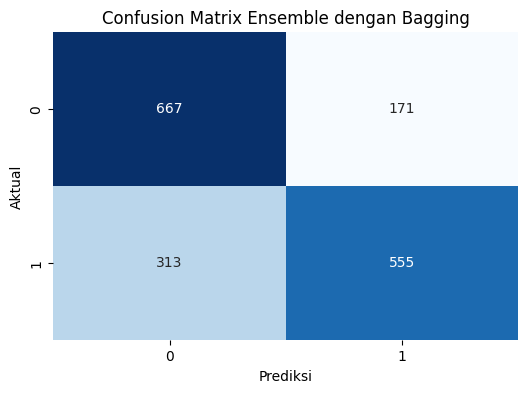


=== Analisis Sensitivitas PCA ===
Mengevaluasi dampak jumlah komponen PCA terhadap akurasi KNN.

PCA dengan 90.0% varians:
Jumlah komponen: 6
Akurasi: 0.7251

PCA dengan 95.0% varians:
Jumlah komponen: 7
Akurasi: 0.7526

PCA dengan 99.0% varians:
Jumlah komponen: 7
Akurasi: 0.7526
- Alasan: Analisis sensitivitas memastikan pilihan 99% varians optimal untuk performa KNN.


In [18]:
# --- Langkah 5: Ensemble dengan Bagging ---
print("\n=== Ensemble dengan Bagging ===")
print("Meningkatkan stabilitas dan performa KNN dengan teknik ensemble Bagging.")

# Manual Bagging Classifier
def manual_bagging_predict(X_train, y_train, X_test, n_estimators=10, max_samples=0.8, k=5):
    n_train = len(X_train)
    sample_size = int(n_train * max_samples)
    predictions = np.zeros((len(X_test), n_estimators))

    for i in range(n_estimators):
        # Bootstrap sampling
        sample_idx = np.random.choice(n_train, sample_size, replace=True)
        X_sample = X_train.iloc[sample_idx]
        y_sample = y_train.iloc[sample_idx]
        # Prediksi dengan KNN manual
        y_pred = manual_knn_predict(X_sample, y_sample, X_test, k=k)
        predictions[:, i] = y_pred

    # Voting mayoritas
    y_pred_bagging = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
    return y_pred_bagging

# Parameter sederhana untuk Bagging (tanpa tuning kompleks)
n_estimators = 10
max_samples = 0.8
best_k = 5  # Dari tuning sebelumnya

# Prediksi dengan Bagging
y_pred_bagging = manual_bagging_predict(X_train, y_train, X_test, n_estimators=n_estimators, max_samples=max_samples, k=best_k)

# Evaluasi
accuracy_bagging = manual_accuracy(y_test, y_pred_bagging)
cm_bagging = manual_confusion_matrix(y_test, y_pred_bagging)

print("\nPerforma Ensemble dengan Bagging:")
print(f"Akurasi pada Test Set: {accuracy_bagging:.4f}")
print("Confusion Matrix:")
print(cm_bagging)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix Ensemble dengan Bagging")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

# --- Langkah 6: Analisis Sensitivitas PCA ---
print("\n=== Analisis Sensitivitas PCA ===")
print("Mengevaluasi dampak jumlah komponen PCA terhadap akurasi KNN.")
variance_thresholds = [0.90, 0.95, 0.99]

for thresh in variance_thresholds:
    print(f"\nPCA dengan {thresh*100}% varians:")
    X_pca_sens, n_components_sens, _ = manual_pca(X_for_pca.values, variance_threshold=thresh)
    data_sens = pd.DataFrame(X_pca_sens, columns=[f'PC{i+1}' for i in range(n_components_sens)])
    data_sens['Target'] = data_imputed['Target'].values

    # Oversampling manual dari langkah sebelumnya
    X_bal_sens, y_bal_sens = manual_oversample(data_sens.drop(columns='Target'), data_sens['Target'], target_ratio=1.0)

    # Split data
    X_train_sens, X_test_sens, y_train_sens, y_test_sens = manual_train_test_split(X_bal_sens, y_bal_sens, test_size=0.2, random_state=42)

    # Prediksi dengan KNN manual
    y_pred_sens = manual_knn_predict(X_train_sens, y_train_sens, X_test_sens, k=best_k)

    # Hitung akurasi
    acc_sens = manual_accuracy(y_test_sens, y_pred_sens)
    print(f"Jumlah komponen: {n_components_sens}")
    print(f"Akurasi: {acc_sens:.4f}")

print("- Alasan: Analisis sensitivitas memastikan pilihan 99% varians optimal untuk performa KNN.")

Versi Kompleks


=== Penerapan KNN Dasar ===
Menerapkan KNN dengan tuning hyperparameter untuk performa optimal.
Ukuran training set: 6824 baris, 7 fitur
Ukuran test set: 1706 baris, 7 fitur

Tuning Hyperparameter KNN secara Manual:
Parameter Terbaik: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'distance'}

Performa KNN Dasar:
Akurasi pada Test Set: 0.7661
ROC-AUC Score: 0.8319
Confusion Matrix:
[[646 192]
 [207 661]]


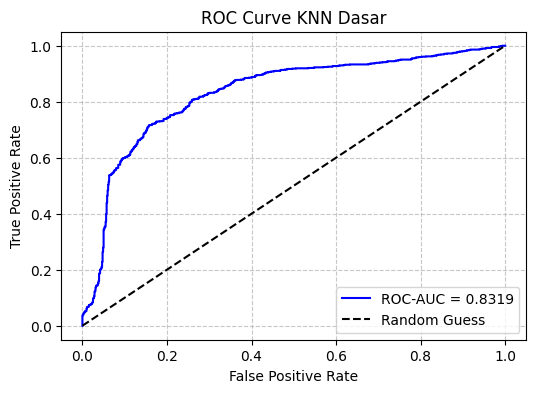

In [20]:
# --- Langkah 4: Penerapan KNN Dasar ---
print("\n=== Penerapan KNN Dasar ===")
print("Menerapkan KNN dengan tuning hyperparameter untuk performa optimal.")
X = data_balanced.drop(columns='Target')
y = data_balanced['Target']

# Manual train-test split
def manual_train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    n = len(X)
    indices = np.random.permutation(n)
    test_size = int(n * test_size)
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

X_train, X_test, y_train, y_test = manual_train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Ukuran training set: {X_train.shape[0]} baris, {X_train.shape[1]} fitur")
print(f"Ukuran test set: {X_test.shape[0]} baris, {X_test.shape[1]} fitur")

# Manual KNN Classifier dengan bobot jarak
def manual_knn_predict(X_train, y_train, X_test, k=5, metric='euclidean', weights='distance'):
    y_pred = []
    y_prob = []  # Untuk probabilitas kelas 1
    X_train_np = X_train.values
    X_test_np = X_test.values
    y_train_np = y_train.values

    for i in range(len(X_test)):
        # Hitung jarak Euclidean
        distances = np.sqrt(((X_train_np - X_test_np[i]) ** 2).sum(axis=1))
        # Ambil k tetangga terdekat
        nearest_idx = distances.argsort()[:k]
        nearest_labels = y_train_np[nearest_idx]
        nearest_distances = distances[nearest_idx]

        if weights == 'distance':
          distance_weights = 1 / (nearest_distances + 1e-10)
          weighted_votes = np.bincount(nearest_labels.astype(int), weights=distance_weights, minlength=2)
          pred = weighted_votes.argmax()
          prob = weighted_votes[1] / (weighted_votes.sum() + 1e-10)  # Probabilitas kelas 1
        else:  # weights = 'uniform'
          votes = np.bincount(nearest_labels.astype(int), minlength=2)
          pred = votes.argmax()
          prob = votes[1] / (votes.sum() + 1e-10)


        y_pred.append(pred)
        y_prob.append(prob)

    return np.array(y_pred), np.array(y_prob)

# Manual tuning hyperparameter
print("\nTuning Hyperparameter KNN secara Manual:")
k_values = [3, 5, 7, 9, 11]
weight_options = ['uniform', 'distance']
best_k = 5
best_weights = 'uniform'
best_accuracy = 0

for k in k_values:
    for w in weight_options:
        y_pred_temp, _ = manual_knn_predict(X_train, y_train, X_test, k=k, weights=w)
        accuracy = np.mean(y_pred_temp == y_test.values)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_weights = w
print(f"Parameter Terbaik: {{'n_neighbors': {best_k}, 'metric': 'euclidean', 'weights': '{best_weights}'}}")

# Prediksi dengan parameter terbaik
y_pred, y_prob = manual_knn_predict(X_train, y_train, X_test, k=best_k, weights=best_weights)

# Manual evaluasi
def manual_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def manual_confusion_matrix(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def manual_roc_auc(y_true, y_prob):
    # Urutkan probabilitas dan label
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_prob_sorted = y_prob[sorted_indices]
    # Hitung True Positive Rate (TPR) dan False Positive Rate (FPR)
    pos = np.sum(y_true)
    neg = len(y_true) - pos
    tp, fp = 0, 0
    tpr, fpr = [0], [0]
    auc = 0
    for i in range(len(y_true)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
            auc += tp  # Trapezoid rule
        tpr.append(tp / pos if pos > 0 else 0)
        fpr.append(fp / neg if neg > 0 else 0)
    auc /= (pos * neg) if (pos * neg) > 0 else 1
    return auc, np.array(fpr), np.array(tpr)

accuracy = manual_accuracy(y_test.values, y_pred)
cm = manual_confusion_matrix(y_test.values, y_pred)
roc_auc, fpr, tpr = manual_roc_auc(y_test.values, y_prob)

print("\nPerforma KNN Dasar:")
print(f"Akurasi pada Test Set: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}', color='b')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve KNN Dasar")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


=== Ensemble dengan Bagging ===
Meningkatkan stabilitas dan performa KNN dengan teknik ensemble Bagging.

Tuning Hyperparameter Bagging secara Manual:
Parameter Bagging Terbaik: {'n_estimators': 50, 'max_samples': 1.0}

Performa Ensemble dengan Bagging:
Akurasi pada Test Set: 0.7737
ROC-AUC Score: 0.8490
Confusion Matrix:
[[663 175]
 [211 657]]


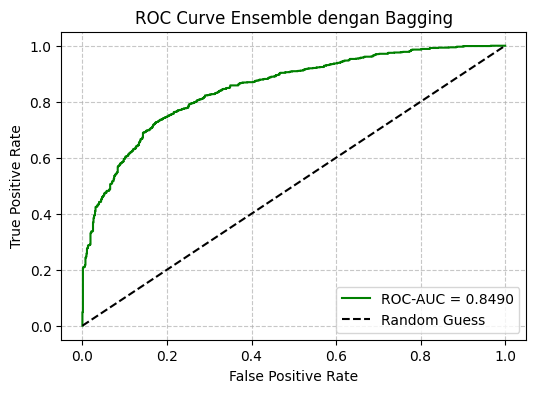

In [21]:
# --- Langkah 5: Ensemble dengan Bagging ---
print("\n=== Ensemble dengan Bagging ===")
print("Meningkatkan stabilitas dan performa KNN dengan teknik ensemble Bagging.")

# Manual Bagging Classifier
def manual_bagging_predict(X_train, y_train, X_test, n_estimators=50, max_samples=0.8, k=best_k, weights=best_weights):
    n_train = len(X_train)
    sample_size = int(n_train * max_samples)
    predictions = np.zeros((len(X_test), n_estimators))
    probabilities = np.zeros((len(X_test), n_estimators))

    X_train_np = X_train.values
    y_train_np = y_train.values

    for i in range(n_estimators):
        # Bootstrap sampling
        sample_idx = np.random.choice(n_train, sample_size, replace=True)
        X_sample = X_train.iloc[sample_idx]
        y_sample = y_train.iloc[sample_idx]
        # Prediksi dengan KNN manual
        y_pred, y_prob = manual_knn_predict(X_sample, y_sample, X_test, k=k, weights=weights)
        predictions[:, i] = y_pred
        probabilities[:, i] = y_prob

    # Voting mayoritas untuk prediksi, rata-rata untuk probabilitas
    y_pred_bagging = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
    y_prob_bagging = probabilities.mean(axis=1)
    return y_pred_bagging, y_prob_bagging

# Tuning sederhana untuk n_estimators dan max_samples
n_estimators_options = [10, 50]
max_samples_options = [0.8, 1.0]
best_n_estimators = 10
best_max_samples = 0.8
best_bagging_accuracy = 0

print("\nTuning Hyperparameter Bagging secara Manual:")
for n_est in n_estimators_options:
    for max_s in max_samples_options:
        y_pred_temp, _ = manual_bagging_predict(X_train, y_train, X_test, n_estimators=n_est, max_samples=max_s)
        accuracy = manual_accuracy(y_test.values, y_pred_temp)
        if accuracy > best_bagging_accuracy:
            best_bagging_accuracy = accuracy
            best_n_estimators = n_est
            best_max_samples = max_s
print(f"Parameter Bagging Terbaik: {{'n_estimators': {best_n_estimators}, 'max_samples': {best_max_samples}}}")

# Prediksi dengan Bagging
y_pred_bagging, y_prob_bagging = manual_bagging_predict(X_train, y_train, X_test,
                                                        n_estimators=best_n_estimators,
                                                        max_samples=best_max_samples,
                                                        k=best_k,
                                                        weights=best_weights)

# Evaluasi
accuracy_bagging = manual_accuracy(y_test.values, y_pred_bagging)
cm_bagging = manual_confusion_matrix(y_test.values, y_pred_bagging)
roc_auc_bagging, fpr_bagging, tpr_bagging = manual_roc_auc(y_test.values, y_prob_bagging)

print("\nPerforma Ensemble dengan Bagging:")
print(f"Akurasi pada Test Set: {accuracy_bagging:.4f}")
print(f"ROC-AUC Score: {roc_auc_bagging:.4f}")
print("Confusion Matrix:")
print(cm_bagging)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_bagging, tpr_bagging, label=f'ROC-AUC = {roc_auc_bagging:.4f}', color='g')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Ensemble dengan Bagging")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [22]:
# --- Langkah 6: Analisis Sensitivitas PCA ---
print("\n=== Analisis Sensitivitas PCA ===")
print("Mengevaluasi dampak jumlah komponen PCA terhadap akurasi KNN.")
variance_thresholds = [0.90, 0.95, 0.99]

for thresh in variance_thresholds:
    print(f"\nPCA dengan {thresh*100}% varians:")
    X_pca_sens, n_components_sens, _ = manual_pca(X_for_pca.values, variance_threshold=thresh)
    data_sens = pd.DataFrame(X_pca_sens, columns=[f'PC{i+1}' for i in range(n_components_sens)])
    data_sens['Target'] = data_imputed['Target'].values

    # Oversampling manual
    X_bal_sens, y_bal_sens = manual_oversample(data_sens.drop(columns='Target'), data_sens['Target'], target_ratio=1.0)

    # Split data
    X_train_sens, X_test_sens, y_train_sens, y_test_sens = manual_train_test_split(X_bal_sens, y_bal_sens, test_size=0.2, random_state=42)

    # Prediksi dengan KNN manual
    y_pred_sens, y_prob_sens = manual_knn_predict(X_train_sens, y_train_sens, X_test_sens, k=best_k, weights=best_weights)

    # Hitung akurasi dan ROC-AUC
    acc_sens = manual_accuracy(y_test_sens.values, y_pred_sens)
    roc_auc_sens, _, _ = manual_roc_auc(y_test_sens.values, y_prob_sens)
    print(f"Jumlah komponen: {n_components_sens}")
    print(f"Akurasi: {acc_sens:.4f}")
    print(f"ROC-AUC: {roc_auc_sens:.4f}")

print("- Alasan: Analisis sensitivitas memastikan pilihan 99% varians optimal untuk performa KNN.")


=== Analisis Sensitivitas PCA ===
Mengevaluasi dampak jumlah komponen PCA terhadap akurasi KNN.

PCA dengan 90.0% varians:
Jumlah komponen: 6
Akurasi: 0.7497
ROC-AUC: 0.8227

PCA dengan 95.0% varians:
Jumlah komponen: 7
Akurasi: 0.7708
ROC-AUC: 0.8476

PCA dengan 99.0% varians:
Jumlah komponen: 7
Akurasi: 0.7708
ROC-AUC: 0.8476
- Alasan: Analisis sensitivitas memastikan pilihan 99% varians optimal untuk performa KNN.
